In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import e

In [2]:
T = 10
nsteps = 20
nsims = 1000
r0 = 0.02
alpha = 3
sigma = 0.01
theta0 = 0.03
beta = 1
phi = 0.05
eta = 0.005

In [3]:
def Sim_Brownian_Motion(t):
    # store the paths of the Brownian motion
    W = np.zeros(len(t))

    sqrt_dt = np.sqrt(t[1] - t[0])
    for i in range(len(t) - 1):
        W[i + 1] = W[i] + sqrt_dt * np.random.randn()

    return W

In [4]:
def risk_neutral_int_elur(r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta):
    dt = t[1] - t[0]

    theta_path = np.zeros(len(t))
    theta_path[0] = theta0

    r_path = np.zeros(len(t))
    r_path[0] = r0

    # Euler theta and r
    for i in range(len(t)-1):
        theta_path[i+1] = theta_path[i] + beta * (phi - theta_path[i]) * dt + eta * (w_sim_theta[i+1] - w_sim_theta[i])
        r_path[i+1] = r_path[i] + alpha * (theta_path[i] - r_path[i]) * dt + sigma * (w_sim_r[i+1] - w_sim_r[i])

    return theta_path, r_path

In [5]:
def bond_price(t1, t2, t, step, r_path):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):
        bank_account[i+1] = bank_account[i] + r_path[i] * bank_account[i] * dt
    return bank_account[t1 * step] / bank_account[t2 * step]

In [6]:
def analytic_a(alpha, beta, sigma, phi, eta, T, t):
    m = e ** -(alpha * (T - t))
    n = e ** -(beta * (T - t))
    p1 = - phi * (T - t)
    p2 = - phi * beta * (1 - m) / (alpha * (alpha - beta))
    p3 = phi * alpha * (1 - n) / (beta * (alpha - beta))
    pb = sigma ** 2 / (2 * alpha ** 2) * (T - t) \
        - sigma ** 2 * (1- m) / alpha ** 3 \
        + sigma ** 2 * (1 - m ** 2) / (4 * alpha ** 3)
    pc = eta ** 2 / (2 * beta ** 2) * (
        (T - t)
        + 2 * beta * (1 - m) / (alpha * (alpha - beta))
        - 2 * alpha * (1 - n) / (beta * (alpha - beta))
        + beta ** 2 * (1 - m ** 2) / (2 * alpha * (alpha - beta) ** 2)
        - 2 * alpha * beta * (1 - m * n) / ((alpha + beta) * (alpha - beta) ** 2)
        + alpha ** 2 * (1 - n ** 2) / (2 * beta * (alpha - beta) ** 2)
    )

    return p1 + p2 + p3 + pb + pc


def analytic_b(alpha, T, t):
    return (1 - e ** -(alpha * (T - t))) / alpha


def analytic_c(alpha, beta, T, t):
    return (1 / beta
            + (beta * e ** -(alpha * (T - t)) - alpha * e ** -(beta * (T - t))) / (beta * (alpha - beta)))

In [7]:
def analytic_formula_curve(r0, alpha, beta, sigma, theta0, phi, eta, T, t):
    return (analytic_b(alpha, T, t) * r0
            + analytic_c(alpha, beta, T, t) * theta0
            - analytic_a(alpha, beta, sigma, phi, eta, T, t)) / (T - t)

### Q4

In [42]:
# Analytic Version\
T1 = 3
T2 = 5

In [43]:
def H1_sq(t1, t2, t, alpha, sigma):
    m1 = np.exp(-alpha*(t1-t))
    m2 = np.exp(-alpha*(t2-t))
    
    temp_H1 = sigma**2/(2*alpha**3) * ((np.exp(-alpha*(t2-t1))-1)**2 - (m2-m1)**2)
    return temp_H1

In [44]:
def H2_sq(t1, t2, t, alpha, beta, sigma, eta):
    
    m1 = np.exp(-alpha*(t1-t))
    m2 = np.exp(-alpha*(t2-t))
    n1 = np.exp(-beta*(t1-t))
    n2 = np.exp(-beta*(t2-t))
    
    p1 = beta**2/(2*alpha) * ((np.exp(-alpha*(t2-t1))-1)**2 - (m2-m1)**2)
    p2 = -2*alpha*beta/(alpha+beta) *((np.exp(-alpha*(t2-t1))-1)*(np.exp(-beta*(t2-t1))-1) - (m2-m1)*(n2-n1))
    p3 = alpha**2/(2*beta) * ((np.exp(-beta*(t2-t1))-1)**2 - (n2-n1)**2)
    
    H2_temp = eta**2/(beta**2 * (alpha-beta)**2) * (p1+p2+p3)
    
    return H2_temp

In [45]:
P0_T1 = np.exp(-analytic_formula_curve(r0, alpha, beta, sigma, theta0, phi, eta, T1, 0)*(T1-0))
P0_T2 = np.exp(-analytic_formula_curve(r0, alpha, beta, sigma, theta0, phi, eta, T2, 0)*(T2-0))
K = P0_T2/P0_T1

In [46]:
H1_T1_sq = H1_sq(T1, T2, 0, alpha, sigma)
H2_T1_sq = H2_sq(T1, T2, 0, alpha, beta, sigma, eta)

In [47]:
K_steps = 11
K_factor = np.linspace(0.95, 1.05, K_steps)
g_T1 = np.zeros(K_steps)

for i in range(0, K_steps):
    
    K_temp = K*K_factor[i]
    
    d1 = (np.log(P0_T2/(K_temp*P0_T1)) + 0.5*(H1_T1_sq+H2_T1_sq))/(np.sqrt(H1_T1_sq+H2_T1_sq))
    d2 = (np.log(P0_T2/(K_temp*P0_T1)) - 0.5*(H1_T1_sq+H2_T1_sq))/(np.sqrt(H1_T1_sq+H2_T1_sq))
    g_T1[i] = P0_T2*norm.cdf(d1) - P0_T1*K_temp*norm.cdf(d2)

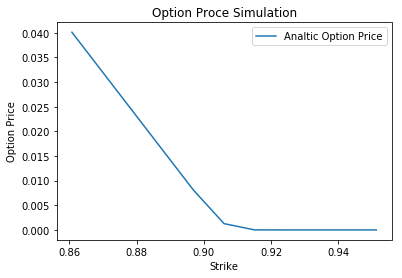

In [49]:
plt.plot(K*K_factor, g_T1, label='Analtic Option Price')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Option Proce Simulation')
plt.legend()

In [50]:
K_factor = np.linspace(0.95, 1.05, 11)
K_factor[10]

1.05

In [20]:
t = np.linspace(0, T, nsteps)

theta_path_set = np.zeros((nsims, nsteps))
r_path_set = np.zeros((nsims, nsteps))

for i in range(0,nsims):
    w_sim_r = Sim_Brownian_Motion(t)
    w_sim_theta = Sim_Brownian_Motion(t)

    theta_path_set[i:], r_path_set[i:] = risk_neutral_int_elur(r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta)


bond_yield = np.average(r_path_set, axis = 0)

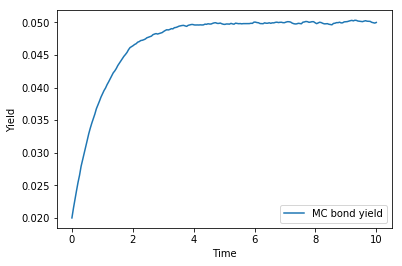

In [21]:
plt.plot(t, bond_yield, label='MC bond yield')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend()

In [ ]:
bond_y_ana = np.zeros(len(t))
for i in t:
    m = np.exp(-alpha*(T-i))
    n = np.exp(-beta*(T-i))
    Bt = (1-m)/alpha
    Ct = 1/beta + (beta*m-alpha*n)/(beta*(alpha-beta))
    big_int_b = sigma**2*(T-i)/(2*alpha**2) - sigma**2*(1-m)/(alpha**3) + sigma**2*(1-m**2)/(4*alpha**3)
    big_int_c = 0.5*eta**2/beta**2 * ((T-i) + 2*beta*(1-m)/(alpha*(alpha-beta)) - 2*alpha*(1-n)/(beta*(alpha-beta)) +\
                                      beta**2 * (1-m**2)/(2*alpha*(alpha-beta)**2) - \
                                      2*beta*alpha * (1-m*n)/((alpha+beta)*(alpha-beta)**2) +\
                                      alpha**2 * (1-n**2)/(2*beta*(alpha-beta)**2))
    At = -phi*(T-i) - phi*beta*(1-m)/(alpha*(alpha - beta)) + phi*alpha*(1-n)/(beta*(alpha-beta)) +big_int_b+big_int_c
    
    
    